# Analyzing Battle Data from Matches in the Mobile Game Clash Royale

### Descriptive: 
- What are some cards with the highest use rates (used the most times)? <br>
- What are some cards with the highest win rates (on winning deck most times)? <br>
- Are use rates and win rates correlated? <br>
- How does player level influence quality of deck? </br>
- Do other card attributes play a role (card levels, card elixir costs, etc.)? <br>

### Predictive:

- Are there cards often paired together? <br>
- What card relationships can we define? <br>
- Can we predict the outcome of a game based on players’ decks?


### Evaluate:

- Does the inclusion of a specific card in the player's deck impact a card's win rates?
- Does the inclusion of a specific card in the opponent's deck impact a card's win rates?
- Does the quality of a player's deck influence their success in gameplay?
- Do players naturally self-select the best deck according to the model as their trophies increase?


<hr>

# Part 1: Insights and Descriptive Data

## Initialize

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# For csv merging from folder
import os

# For parsing key-value pairs in dataframe
import ast

# For stats analysis
from scipy import stats

# For basket analysis
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# For Counter / Synergy
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

# For Predictive Model
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

## Merge CSVs into Single Dataframe

In [ ]:
# Set the path to the directory containing the CSV files
path = '/content/drive/MyDrive/ME 379M/Hackathon 2023/Data'

# Create an empty list to store the DataFrames
dfs = []

# Iterate through all files in the directory and check if the file is a CSV file
for file in os.listdir(path):
    if file.endswith('.csv'):
        # read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(os.path.join(path, file))
        dfs.append(df)

# Concatenate all DataFrames into one final DataFrame
battle_data_df = pd.concat(dfs, axis=0, ignore_index=True)

print(len(battle_data_df))

870486


In [ ]:
print("Imported Length:", len(battle_data_df))

# Clean data by removing rows with empty cells
battle_data_df = battle_data_df.dropna()
print("Without N/A:", len(battle_data_df))

# Filter out for competitive gamemodes only
unique_values = ['PvP', 'pathOfLegend']
battle_data_df = battle_data_df[battle_data_df['type'].isin(unique_values)]
print("With Filtered Game Modes:", len(battle_data_df))

Imported Length: 870486
Without N/A: 673737
With Filtered Game Modes: 305297


In [ ]:
battle_data_df.head()

,type,gameMode,crowns1,cards1,startingTrophies2,crowns2,cards2
2,PvP,"{'id': 72000006, 'name': 'Ladder'}",2,"[{'name': 'Bomber', 'id': 26000013, 'level': 9...",1518.0,1,"[{'name': 'Valkyrie', 'id': 26000011, 'level':..."
3,PvP,"{'id': 72000006, 'name': 'Ladder'}",0,"[{'name': 'Bomber', 'id': 26000013, 'level': 9...",1540.0,1,"[{'name': 'Mini P.E.K.K.A', 'id': 26000018, 'l..."
5,PvP,"{'id': 72000006, 'name': 'Ladder'}",1,"[{'name': 'Bomber', 'id': 26000013, 'level': 9...",1509.0,0,"[{'name': 'Knight', 'id': 26000000, 'level': 7..."
6,PvP,"{'id': 72000006, 'name': 'Ladder'}",1,"[{'name': 'Bomber', 'id': 26000013, 'level': 8...",1446.0,0,"[{'name': 'Goblin Giant', 'id': 26000060, 'lev..."
7,PvP,"{'id': 72000006, 'name': 'Ladder'}",1,"[{'name': 'Bomber', 'id': 26000013, 'level': 8...",1438.0,0,"[{'name': 'Bomber', 'id': 26000013, 'level': 7..."


## Take Random Sample from DataFrame for Performance

In [ ]:
sample_battle_data_df = battle_data_df.sample(n=50000,random_state=42)

In [ ]:
pd.set_option('display.max_colwidth', 50) 

## Replace Key-Value Pairs from API Request for Preprocessing

In [ ]:
# Parsing card data for player 1
sample_battle_data_df['cards1_dict'] = sample_battle_data_df['cards1'].apply(lambda x: ast.literal_eval(x))
sample_battle_data_df['deck1'] = sample_battle_data_df['cards1_dict'].apply(lambda x: [a['name'] for a in x])
sample_battle_data_df['max_level_1'] = sample_battle_data_df['cards1_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_battle_data_df['level_1'] = sample_battle_data_df['cards1_dict'].apply(lambda x: [a['level'] for a in x])

In [ ]:
# Parsing card data for player 2
sample_battle_data_df['cards2_dict'] = sample_battle_data_df['cards2'].apply(lambda x: ast.literal_eval(x))
sample_battle_data_df['deck2'] = sample_battle_data_df['cards2_dict'].apply(lambda x: [a['name'] for a in x])
sample_battle_data_df['max_level_2'] = sample_battle_data_df['cards2_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_battle_data_df['level_2'] = sample_battle_data_df['cards2_dict'].apply(lambda x: [a['level'] for a in x])

## Import Card Data

In [ ]:
# Importing card data to add elixir costs
card_stats_df = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/Card Stats/card_info.csv')
card_stats_df.head()

,name,cost,category,type,hitpoints,damage,dps,count,total_hitpoints,total_damage,total_dps
0,Knight,3,Melee,Troop,2339.0,267,222.0,1,2339,267,222.0
1,Archers,3,Ranged,Troop,403.0,142,157.0,2,806,284,314.0
2,Goblins,2,Swarm,Troop,267.0,159,144.0,4,1068,636,576.0
3,Giant,5,Tank,Troop,5423.0,337,224.0,1,5423,337,224.0
4,P.E.K.K.A,7,Tank,Troop,4982.0,1081,600.0,1,4982,1081,600.0


### Compute Elixir Costs from Raw Data

In [ ]:
# Define a function to compute the elixir costs for a deck
def compute_elixir_costs(deck):
    card_costs = dict(zip(card_stats_df['name'], card_stats_df['cost']))
    elixir_costs = [card_costs.get(card, None) for card in deck if card not in [None, 'None']]
    return elixir_costs

# Compute the elixir costs for the 'deck1' column and replace it with the result
sample_battle_data_df['elixir_costs_1'] = sample_battle_data_df['deck1'].apply(compute_elixir_costs)

# Compute the elixir costs for the 'deck2' column and replace it with the result
sample_battle_data_df['elixir_costs_2'] = sample_battle_data_df['deck2'].apply(compute_elixir_costs)

# Drop rows with elixir_costs as None
sample_battle_data_df.dropna(subset=['elixir_costs_1', 'elixir_costs_2'], inplace=True)

In [ ]:
# Drop key-value pair columns now that data is extracted
sample_battle_data_df.drop(['cards1','cards2','cards1_dict','cards2_dict'],axis=1,inplace=True)

In [ ]:
# Function that merges two lists by making a list of tuple values of each list
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(len(list1))]
    return merged_list

* Because Clash Royale used to have a very poorly designed leveling system, and it's analytics hasn't changed, it's analytics still tracks it using the old system
* Using formula below from google to scale it to new level system


In [ ]:
sample_battle_data_df['cards_level_1'] = [[x-y+14 for x,y in merge(sample_battle_data_df['level_1'].iloc[i],sample_battle_data_df['max_level_1'].iloc[i])] 
                                          for i in range(len(sample_battle_data_df))]
sample_battle_data_df['cards_level_2'] = [[x-y+14 for x,y in merge(sample_battle_data_df['level_2'].iloc[i],sample_battle_data_df['max_level_2'].iloc[i])] 
                                          for i in range(len(sample_battle_data_df))]

In [ ]:
# Averaging card levels from each player's deck
sample_battle_data_df['avg_cards_level_1'] = [sum(x)/8 for x in sample_battle_data_df['cards_level_1']]
sample_battle_data_df['avg_cards_level_2'] = [sum(x)/8 for x in sample_battle_data_df['cards_level_2']]

# Calculate the card level differential (Player 2 Avg - Player 1 Avg)
sample_battle_data_df['avg_cards_level_diff'] = sample_battle_data_df['avg_cards_level_2']-sample_battle_data_df['avg_cards_level_1']

In [ ]:
# Averaging elixir costs from each player's deck
sample_battle_data_df['avg_cost_1'] = [sum(x)/8 for x in sample_battle_data_df['elixir_costs_1']]
sample_battle_data_df['avg_cost_2'] = [sum(x)/8 for x in sample_battle_data_df['elixir_costs_2']]

# Calculate the elixir cost differential (Player 2 Avg - Player 1 Avg)
sample_battle_data_df['avg_cost_diff'] = sample_battle_data_df['avg_cost_2']-sample_battle_data_df['avg_cost_1']

In [ ]:
# Changing crowns data into winning data for simplicity
sample_battle_data_df['crowns_won'] = sample_battle_data_df['crowns2'] - sample_battle_data_df['crowns1']
sample_battle_data_df['winner'] = 0
sample_battle_data_df['winner'].loc[sample_battle_data_df['crowns_won']>0] = 2
sample_battle_data_df['winner'].loc[sample_battle_data_df['crowns_won']<0] = 1

In [ ]:
# Checking how often there is a tie
count = (sample_battle_data_df['crowns_won']==0).sum()
print(count)

3


In [ ]:
# Drop ties from the sample
zero_rows = sample_battle_data_df.loc[sample_battle_data_df['crowns_won'] == 0]

# drop the zero rows from the dataframe
sample_battle_data_df.drop(zero_rows.index, inplace=True)

# Checking how often there is a tie
count = (sample_battle_data_df['crowns_won']==0).sum()
print(count)

0


In [ ]:
sample_battle_data_df.drop(['max_level_1','level_1','max_level_2','level_2','cards_level_1','cards_level_2','elixir_costs_1','elixir_costs_2'],axis=1,inplace=True)

In [ ]:
sample_battle_data_df.head()

,type,gameMode,crowns1,startingTrophies2,crowns2,deck1,deck2,avg_cards_level_1,avg_cards_level_2,avg_cards_level_diff,avg_cost_1,avg_cost_2,avg_cost_diff,crowns_won,winner
596852,PvP,"{'id': 72000044, 'name': 'Ladder_GoldRush'}",0,6063.0,2,"[Tesla, Electro Wizard, Elite Barbarians, The ...","[Bandit, Baby Dragon, Wizard, Valkyrie, Ice Go...",14.000,14.000,0.000,3.750,4.000,0.250,2,2
286297,PvP,"{'id': 72000201, 'name': 'Ladder_CrownRush'}",0,5807.0,1,"[Mega Knight, Bats, Skeleton Army, Valkyrie, M...","[Arrows, Baby Dragon, Firecracker, Tombstone, ...",13.625,13.500,-0.125,3.875,3.750,-0.125,1,2
632413,challenge,"{'id': 72000291, 'name': 'Challenge_AllCards_E...",0,4884.0,2,"[Goblin Gang, Baby Dragon, Fireball, Royal Gho...","[Mega Knight, Witch, Mirror, Tesla, Flying Mac...",11.000,11.000,0.000,3.375,3.875,0.500,2,2
675768,PvP,"{'id': 72000044, 'name': 'Ladder_GoldRush'}",3,5512.0,0,"[Goblin Barrel, Arrows, Hog Rider, Witch, Valk...","[Goblin Barrel, Electro Wizard, Golden Knight,...",12.875,12.625,-0.250,3.500,4.125,0.625,-3,1
273613,PvP,"{'id': 72000201, 'name': 'Ladder_CrownRush'}",1,7180.0,0,"[P.E.K.K.A, Dark Prince, Mother Witch, Electro...","[Golem, Graveyard, Skeleton King, Phoenix, Fly...",14.000,13.875,-0.125,4.125,4.500,0.375,-1,1


### Graph of Player Rankings
Most players fall in the 5000~6000 trophy range

<Axes: ylabel='Density'>

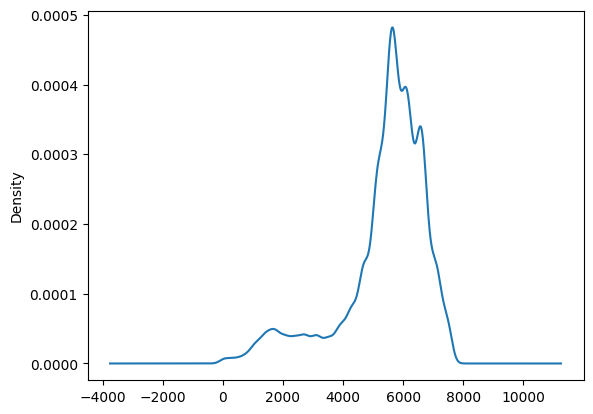

In [ ]:
sample_battle_data_df['startingTrophies2'].plot.kde(bw_method=0.1)

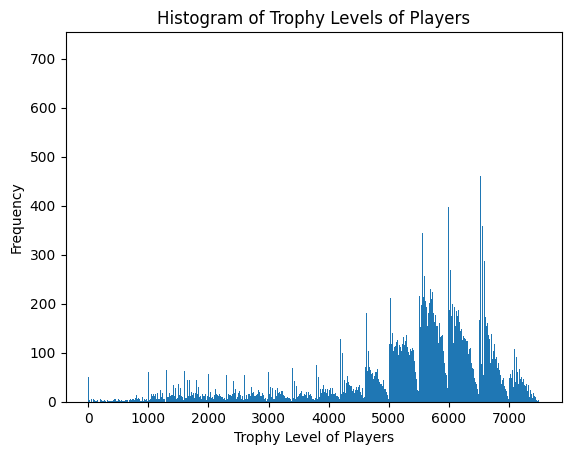

In [ ]:
# Create a histogram with 10 bins
plt.hist(sample_battle_data_df['startingTrophies2'],bins = 1000)

# Add x and y labels and a title
plt.xlabel('Trophy Level of Players')
plt.ylabel('Frequency')
plt.title('Histogram of Trophy Levels of Players')

# Display the histogram
plt.show()

In [ ]:
sample_battle_data_df['avg_cards_level_diff'].describe()

count    49997.000000
mean        -0.074457
std          0.610059
min         -4.750000
25%         -0.250000
50%          0.000000
75%          0.000000
max          5.250000
Name: avg_cards_level_diff, dtype: float64

## Calculate Use and Win Rates

In [ ]:
# Get full list of cards
full_list = list(set([card for row in sample_battle_data_df['deck2'] for card in row]))

In [ ]:
# Make a dataframe of cards used
cards_df = pd.DataFrame(index=full_list)

In [ ]:
card_stats_df.describe()

,cost,hitpoints,damage,dps,count,total_hitpoints,total_damage,total_dps
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,3.981651,1376.169725,341.550459,173.091743,1.522936,1627.293578,428.853211,243.977064
std,1.592701,1392.336941,336.221006,156.809704,1.664423,1500.020347,382.116179,259.271472
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,305.000000,159.000000,0.000000,1.000000,528.000000,212.000000,0.000000
50%,4.000000,1109.000000,267.000000,160.000000,1.000000,1278.000000,324.000000,206.000000
75%,5.000000,1908.000000,381.000000,252.000000,1.000000,2248.000000,486.000000,320.000000
max,9.000000,6784.000000,1967.000000,665.000000,15.000000,6784.000000,1967.000000,1620.000000


In [ ]:
def compute_cost(card_name):
    if card_name == None:
        return 0
    return card_stats_df.loc[card_stats_df['name'] == card_name, 'cost'].iloc[0]
cards_df['Cost'] = 0
for card_name in cards_df.index.tolist():
    cards_df.loc[card_name, 'Cost'] = compute_cost(card_name)
    if card_name == 'None':
        cards_df = cards_df.drop(cards_df[cards_df['name'] == card_name].index)

In [ ]:
# Tally the uses of these by player 2
# Using only player 2 data for simplicity in calculating win rate
cards_df['Count'] = 0
for card in cards_df.index:
    count = 0
    for i in range(len(sample_battle_data_df)):
        if card in sample_battle_data_df['deck2'].iloc[i]:
            count+=1
    cards_df['Count'][card] = count

In [ ]:
# Filter out wins for player 2 then count number of wins per card
cards_df['Wins'] = 0
win_df = sample_battle_data_df.loc[sample_battle_data_df['winner']==2].reset_index()
for card in cards_df.index:
    count = 0
    for i in range(len(win_df)):
        if card in win_df['deck2'].iloc[i]:
            count+=1
    cards_df['Wins'][card] = count

In [ ]:
cards_df['Use_Rate'] = round(cards_df['Count']/len(sample_battle_data_df), 3)
cards_df['Win_Rate'] = round(cards_df['Wins']/cards_df['Count'],3)
pd. set_option('display.max_rows', 20)
cards_df.sort_values(by=['Win_Rate'],ascending=False)

,Cost,Count,Wins,Use_Rate,Win_Rate
Three Musketeers,9,544,310,0.011,0.570
Goblin Giant,6,1228,659,0.025,0.537
Phoenix,4,2140,1146,0.043,0.536
Rascals,5,808,432,0.016,0.535
None,0,2837,1513,0.057,0.533
...,...,...,...,...,...
Goblin Drill,4,859,368,0.017,0.428
Elixir Golem,3,2029,861,0.041,0.424
Giant,5,2955,1244,0.059,0.421
X-Bow,6,970,397,0.019,0.409


## Tables and Plots

### Tables of Top Use Rate and Win Rate

In [ ]:
cards_df.describe()

,Cost,Count,Wins,Use_Rate,Win_Rate
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,3.945455,3636.145455,1754.327273,0.072727,0.482282
std,1.630199,3290.579539,1597.598973,0.065756,0.027120
min,0.000000,374.000000,148.000000,0.007000,0.396000
25%,3.000000,1290.500000,643.250000,0.026250,0.468000
50%,4.000000,2525.500000,1203.500000,0.050500,0.482000
75%,5.000000,4430.250000,2106.250000,0.088750,0.498000
max,9.000000,15551.000000,7497.000000,0.311000,0.570000


In [ ]:
# Sort by highest win rate
top_winners_df = cards_df.sort_values(by=['Win_Rate'],ascending=False).head(15)
top_winners_df

,Cost,Count,Wins,Use_Rate,Win_Rate
Three Musketeers,9,544,310,0.011,0.570
Goblin Giant,6,1228,659,0.025,0.537
Phoenix,4,2140,1146,0.043,0.536
Rascals,5,808,432,0.016,0.535
None,0,2837,1513,0.057,0.533
Cannon Cart,5,1008,532,0.020,0.528
Lightning,6,2831,1483,0.057,0.524
Skeleton Barrel,3,2264,1180,0.045,0.521
Electro Spirit,1,1565,812,0.031,0.519
Monk,5,666,344,0.013,0.517


In [ ]:
# Sort by highest use rate
top_used_df = cards_df.sort_values(by=['Use_Rate'],ascending=False).head(15)
top_used_df

,Cost,Count,Wins,Use_Rate,Win_Rate
Valkyrie,4,15551,7497,0.311,0.482
The Log,2,14906,7494,0.298,0.503
Skeleton Army,3,12291,5862,0.246,0.477
Arrows,3,12174,5886,0.243,0.483
Mega Knight,7,11971,5982,0.239,0.500
Wizard,5,11763,5497,0.235,0.467
Fireball,4,11571,5479,0.231,0.474
Witch,5,10888,5204,0.218,0.478
Hog Rider,4,10100,4881,0.202,0.483
Goblin Barrel,3,10055,4833,0.201,0.481


### Plot of use rate vs win rate of a card



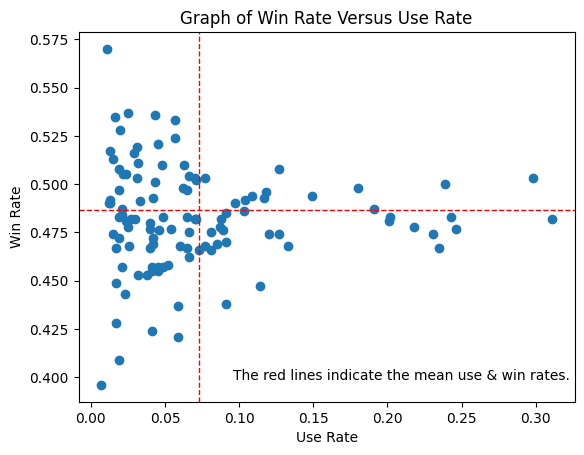

In [ ]:
# plot the data
plt.plot(cards_df['Use_Rate'], cards_df['Win_Rate'], linestyle='none', marker = 'o')

# set the axis labels and title
plt.xlabel('Use Rate')
plt.ylabel('Win Rate')
plt.title('Graph of Win Rate Versus Use Rate')

# Annotation
plt.axvline(0.072745, color='r', linestyle = '--', linewidth = 1)
plt.axhline(0.486645, color='r', linestyle = '--', linewidth = 1)

# add annotation to the plot
plt.annotate('The red lines indicate the mean use & win rates.', 
             xy=(0.99, 0.05), 
             xycoords='axes fraction',
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom')

# display the plot
plt.show()

### Plot of Win Rate Versus Cost

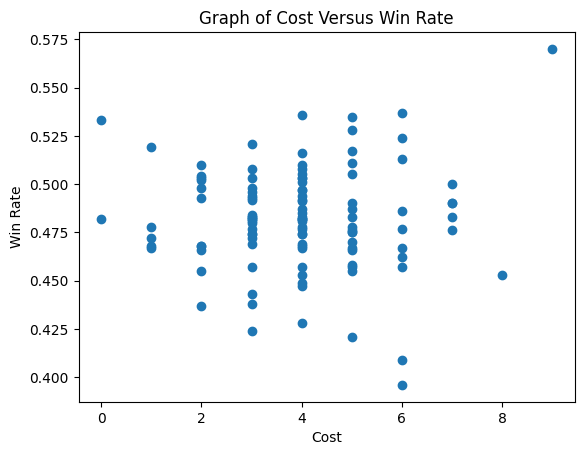

In [ ]:
plt.plot(cards_df['Cost'], cards_df['Win_Rate'], linestyle='none', marker = 'o')

plt.xlabel('Cost')
plt.ylabel('Win Rate')
plt.title('Graph of Cost Versus Win Rate')
plt.show()

### Plot of Use Rate Versus Cost

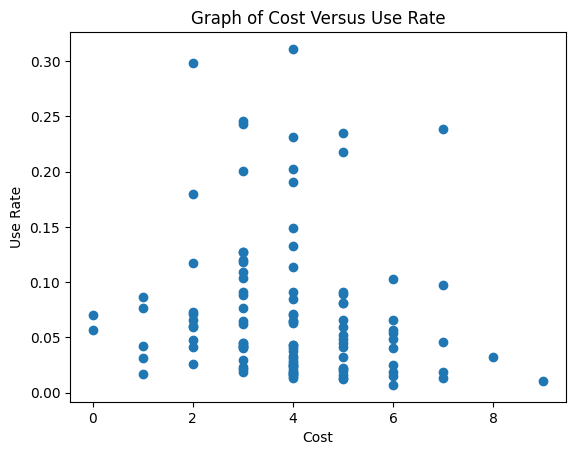

In [ ]:
plt.plot(cards_df['Cost'], cards_df['Use_Rate'], linestyle='none', marker = 'o')

plt.xlabel('Cost')
plt.ylabel('Use Rate')
plt.title('Graph of Cost Versus Use Rate')

plt.show()

### Plot of Average Deck Level Versus Trophy Ranking

In [ ]:
# Create a new variable for the match that computes the average deck level 
sample_battle_data_df['avg_deck_level'] = (sample_battle_data_df['avg_cards_level_1'] + sample_battle_data_df['avg_cards_level_2'])/2

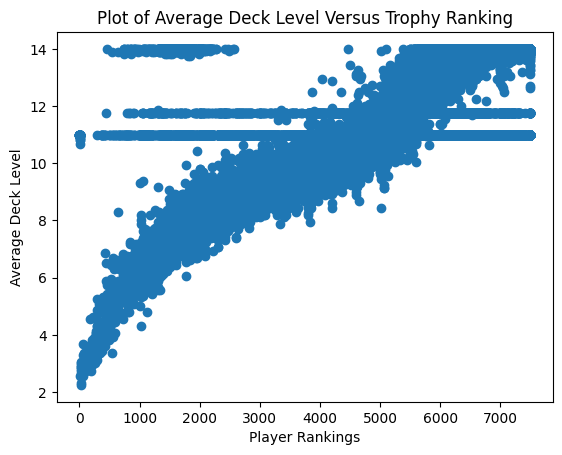

In [ ]:
# plot the data
plt.plot(sample_battle_data_df['startingTrophies2'], sample_battle_data_df['avg_deck_level'], linestyle='none', marker = 'o')

# set the axis labels and title
plt.xlabel('Player Rankings')
plt.ylabel('Average Deck Level')
plt.title('Plot of Average Deck Level Versus Trophy Ranking')

# display the plot
plt.show()

#### When we saw this plot we thought if we built a classifying model for the gamemode that neutralizes deck level we could isolate card combinations as a predictor of victory. It turns out from our model that card combinations alone do not predict victory. 

##### https://colab.research.google.com/drive/1dfbxzO7rwugKRGXUNfs5BdYJEo3zPSCI?usp=sharing

### Plot of Average Deck Elixir Cost Versus Trophy Ranking

In [ ]:
# Create a new variable for the match that computes the average deck level 
sample_battle_data_df['avg_elixir_cost'] = (sample_battle_data_df['avg_cost_1'] + sample_battle_data_df['avg_cost_2'])/2
sample_battle_data_df.head()

,type,gameMode,crowns1,startingTrophies2,crowns2,deck1,deck2,avg_cards_level_1,avg_cards_level_2,avg_cards_level_diff,avg_cost_1,avg_cost_2,avg_cost_diff,crowns_won,winner,avg_deck_level,avg_elixir_cost
596852,PvP,"{'id': 72000044, 'name': 'Ladder_GoldRush'}",0,6063.0,2,"[Tesla, Electro Wizard, Elite Barbarians, The ...","[Bandit, Baby Dragon, Wizard, Valkyrie, Ice Go...",14.000,14.000,0.000,3.750,4.000,0.250,2,2,14.0000,3.8750
286297,PvP,"{'id': 72000201, 'name': 'Ladder_CrownRush'}",0,5807.0,1,"[Mega Knight, Bats, Skeleton Army, Valkyrie, M...","[Arrows, Baby Dragon, Firecracker, Tombstone, ...",13.625,13.500,-0.125,3.875,3.750,-0.125,1,2,13.5625,3.8125
632413,challenge,"{'id': 72000291, 'name': 'Challenge_AllCards_E...",0,4884.0,2,"[Goblin Gang, Baby Dragon, Fireball, Royal Gho...","[Mega Knight, Witch, Mirror, Tesla, Flying Mac...",11.000,11.000,0.000,3.375,3.875,0.500,2,2,11.0000,3.6250
675768,PvP,"{'id': 72000044, 'name': 'Ladder_GoldRush'}",3,5512.0,0,"[Goblin Barrel, Arrows, Hog Rider, Witch, Valk...","[Goblin Barrel, Electro Wizard, Golden Knight,...",12.875,12.625,-0.250,3.500,4.125,0.625,-3,1,12.7500,3.8125
273613,PvP,"{'id': 72000201, 'name': 'Ladder_CrownRush'}",1,7180.0,0,"[P.E.K.K.A, Dark Prince, Mother Witch, Electro...","[Golem, Graveyard, Skeleton King, Phoenix, Fly...",14.000,13.875,-0.125,4.125,4.500,0.375,-1,1,13.9375,4.3125


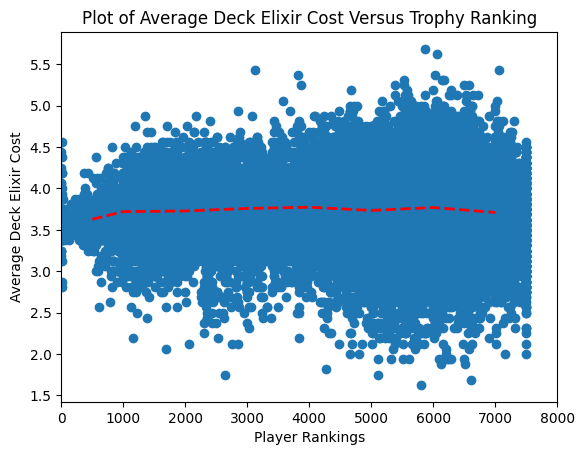

In [ ]:
# define the ranges for x
ranges = [(500, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000), (5000, 6000), (6000, 7000), (7000, 7500)]

# calculate the mean of y for each range of x values
mean_y = []
for r in ranges:
    mask = (sample_battle_data_df['startingTrophies2'] >= r[0]) & (sample_battle_data_df['startingTrophies2'] < r[1])
    mean_y.append(sample_battle_data_df.loc[mask, 'avg_elixir_cost'].mean())

# plot the data
plt.plot(sample_battle_data_df['startingTrophies2'], sample_battle_data_df['avg_elixir_cost'], linestyle='none', marker = 'o')

# plot the mean values as a line
plt.plot([r[0] for r in ranges], mean_y, color='red', linestyle='dashed', linewidth=2)

# set the axis labels and title
plt.xlabel('Player Rankings')
plt.ylabel('Average Deck Elixir Cost')
plt.title('Plot of Average Deck Elixir Cost Versus Trophy Ranking')

#
plt.xlim(0,8000)

# display the plot
plt.show()

### Plot of Deck Levels Versus Trophy Ranking for Winning and Losing Sides

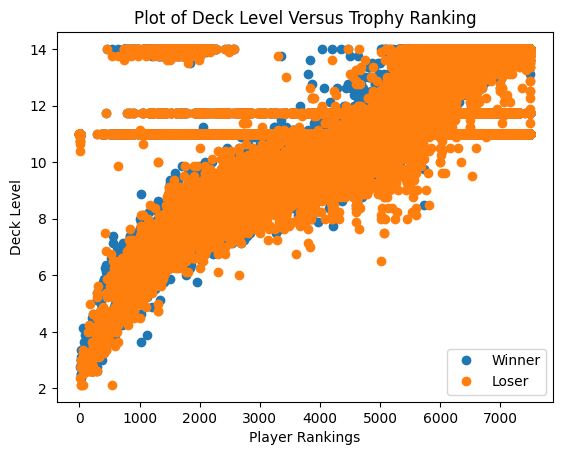

In [ ]:
# create subset of dataframe for winning sides
one_df = sample_battle_data_df.loc[sample_battle_data_df['winner']==1]
two_df = sample_battle_data_df.loc[sample_battle_data_df['winner']==2]

winning_set = one_df['startingTrophies2'].to_list() + two_df['startingTrophies2'].to_list()
winning_hands = one_df['avg_cards_level_1'].to_list() + two_df['avg_cards_level_2'].to_list()
losing_hands = one_df['avg_cards_level_2'].to_list() + two_df['avg_cards_level_1'].to_list()

# p
plt.plot(winning_set, winning_hands, linestyle='none', marker = 'o', label='Winner')
plt.plot(winning_set, losing_hands, linestyle='none', marker = 'o', label='Loser')

plt.xlabel('Player Rankings')
plt.ylabel('Deck Level')
plt.title('Plot of Deck Level Versus Trophy Ranking')
plt.legend()

plt.show()

### Plot of Elixir Costs Versus Trophy Rankings for Winning and Losing Sides

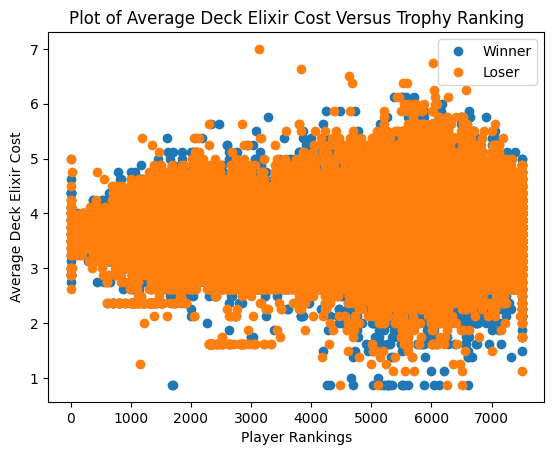

In [ ]:
winning_elixir = one_df['avg_cost_1'].to_list() + two_df['avg_cost_2'].to_list()
losing_elixir = one_df['avg_cost_2'].to_list() + two_df['avg_cost_1'].to_list()

plt.plot(winning_set, winning_elixir, linestyle='none', marker = 'o', label='Winner')
plt.plot(winning_set, losing_elixir, linestyle='none', marker = 'o', label='Loser')

plt.xlabel('Player Rankings')
plt.ylabel('Average Deck Elixir Cost')
plt.title('Plot of Average Deck Elixir Cost Versus Trophy Ranking')
plt.legend()

plt.show()

### Plot of Card Elixir Cost Versus Use Rate

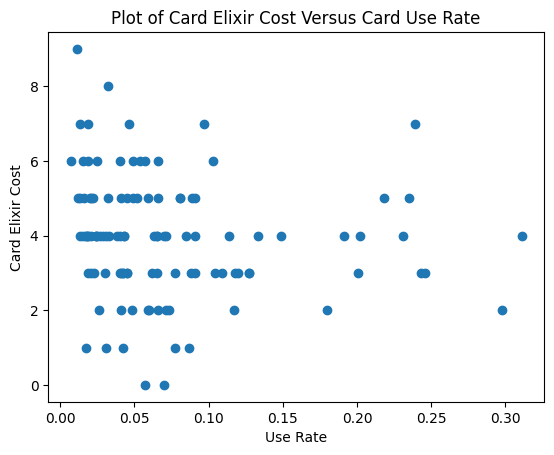

In [ ]:
# plot the data
plt.plot(cards_df['Use_Rate'], cards_df['Cost'], linestyle='none', marker = 'o')

# set the axis labels and title
plt.xlabel('Use Rate')
plt.ylabel('Card Elixir Cost')
plt.title('Plot of Card Elixir Cost Versus Card Use Rate')

# display the plot
plt.show()

## Comparing Win Rates - Card Analysis
- The T test indicates that the win rate of cards follows a uniform distribution.
- Clash Royale is a well balanced game
- Card-level analysis alone is not good enough for finding winning factor.

In [ ]:
# Perform T-Test to see if win rate distance is uniform
random_vars = cards_df['Win_Rate'].to_numpy()
base_dist = np.linspace((sample_battle_data_df['winner']-1).mean(), (sample_battle_data_df['winner']-1).mean())
stats.ttest_ind(random_vars, base_dist)

Ttest_indResult(statistic=-0.04870767380508112, pvalue=0.961213776218154)

## Find Cards that Synergize With/Counter Each Other
- **Synergize**: Win rates increase when another specific card is paired
- **Counter**: Win rates go down when opponent has another specific card

Finding synergies (needed attributes):
- Wins: X with Y
- Loses: X without Y

Finding counters (needed attributes):
- Wins: X against deck with Y
- Wins: X against deck without Y
- Loses: X against deck with Y
- Loses: X against deck without Y

In [ ]:
def find_counter_list(card_object, card_object_list, dataframe):
    # Grab every card except for the card itself
    search_list = full_list.copy()
    search_list.remove(card_object)
    result = pd.DataFrame(columns=['Counter','Match_Count','Win_Count','Win_Rate','Match_Count_Without_Card','Win_Count_Without_Card','Win_Rate_Without_Card'])

    # Create empty lists to store information about each card in the search_list
    Counter_card = []
    Match_Count = []
    Win_Count = []
    Match_Count_B = []
    Win_Count_B = []

    # For each card in the compiled search list:
    for counter in search_list:
        wins = 0
        matches = 0
        wins_B = 0
        matches_B = 0

        # Get all rows of the DataFrame where player 2 has the counter and player 1 has the card_object
        p2 = dataframe.loc[(dataframe['deck1'].apply(lambda x: (card_object in x) & (counter not in x))) & (dataframe['deck2'].apply(lambda x: (counter in x) & (card_object not in x)))]
        # Count the number of wins and matches for player 1
        wins += len(p2.loc[p2['winner']==1])
        matches += len(p2)

        # Get all rows of the DataFrame where player 2 has the counter and neither player has the card_object
        p2B = dataframe.loc[(dataframe['deck1'].apply(lambda x: (card_object in x) & (counter not in x))) & (dataframe['deck2'].apply(lambda x: (counter not in x) & (card_object not in x)))]
        # Count the number of wins and matches for player 1 in this scenario
        wins_B += len(p2B.loc[p2B['winner']==1])
        matches_B += len(p2B)

        # Get all rows of the DataFrame where player 1 has the counter and player 2 has the card_object
        p1 = dataframe.loc[(dataframe['deck1'].apply(lambda x: (counter in x) & (card_object not in x))) & (dataframe['deck2'].apply(lambda x: (card_object in x) & (counter not in x)))]
        # Count the number of wins and matches for player 2
        wins += len(p1.loc[p1['winner']==2])
        matches += len(p1)

        # Get all rows of the DataFrame where player 1 has the counter and neither player has the card_object
        p1B = dataframe.loc[(dataframe['deck1'].apply(lambda x: (counter not in x) & (card_object not in x))) & (dataframe['deck2'].apply(lambda x: (card_object in x) & (counter not in x)))]
        # Count the number of wins and matches for player 2 in this scenario
        wins_B += len(p1B.loc[p1B['winner']==2])
        matches_B += len(p1B)

        # Append data to lists 
        Counter_card.append(counter)
        Win_Count.append(wins)
        Match_Count.append(matches)
        Match_Count_B.append(matches_B)
        Win_Count_B.append(wins_B)

    # Create result dataframe columns
    result['Counter'] = Counter_card
    result['Match_Count'] = Match_Count
    result['Win_Count'] = Win_Count
    result['Win_Rate'] = result['Win_Count']/result['Match_Count']
    result['Match_Count_Without_Card'] = Match_Count_B
    result['Win_Count_Without_Card'] = Win_Count_B
    result['Win_Rate_Without_Card'] = result['Win_Count_Without_Card']/result['Match_Count_Without_Card']

    # Normalize columns without card
    result['Match_Count_Without_Card'] = result['Match_Count']
    result['Win_Count_Without_Card_f'] = result['Match_Count_Without_Card']*result['Win_Rate_Without_Card']
    result['Win_Count_Without_Card'] = round(result['Win_Count_Without_Card_f'],0)
    result.drop(['Win_Count_Without_Card_f'],axis=1,inplace=True)
    return result

In [ ]:
def find_synergy_list(card_object, card_object_list, dataframe):
    # Grab every card except for the card itself
    search_list = full_list.copy()
    search_list.remove(card_object)
    result = pd.DataFrame(columns=['Synergy','Match_Count','Win_Count','Win_Rate','Match_Count_Without_Card','Win_Count_Without_Card','Win_Rate_Without_Card'])

    # Create empty lists to store information about each card in the search_list
    Synergy_card = []
    Match_Count = []
    Win_Count = []
    Match_Count_B = []
    Win_Count_B = []

    # For each card in the compiled search list:
    for synergy in search_list:
        wins = 0
        matches = 0
        wins_B = 0
        matches_B = 0

        # Get all rows of the DataFrame where player 2 has the synergy and the card_object
        p2 = dataframe.loc[(dataframe['deck2'].apply(lambda x: (synergy in x) & (card_object in x)))]
        # Count the number of wins and matches for player 2
        wins += len(p2.loc[p2['winner']==2])
        matches += len(p2)

        # Get all rows of the DataFrame where player 2 has the  card_object, but not the synergy
        p2B = dataframe.loc[(dataframe['deck2'].apply(lambda x: (synergy not in x) & (card_object in x)))]
        # Count the number of wins and matches for player 1 in this scenario
        wins_B += len(p2B.loc[p2B['winner']==1])
        matches_B += len(p2B)

        # Get all rows of the DataFrame where player 1 has the synergy and the card_object
        p1 = dataframe.loc[(dataframe['deck1'].apply(lambda x: (synergy in x) & (card_object in x)))]
        # Count the number of wins and matches for player 1
        wins += len(p1.loc[p1['winner']==1])
        matches += len(p1)

        # Get all rows of the DataFrame where player 1 has the  card_object, but not the synergy
        p1B = dataframe.loc[(dataframe['deck1'].apply(lambda x: (synergy not in x) & (card_object in x)))]
        # Count the number of wins and matches for player 2 in this scenario
        wins_B += len(p1B.loc[p1B['winner']==2])
        matches_B += len(p1B)

        # Append data to lists 
        Synergy_card.append(synergy)
        Win_Count.append(wins)
        Match_Count.append(matches)
        Match_Count_B.append(matches_B)
        Win_Count_B.append(wins_B)

    # Create result dataframe columns
    result['Synergy'] = Synergy_card
    result['Match_Count'] = Match_Count
    result['Win_Count'] = Win_Count
    result['Win_Rate'] = result['Win_Count']/result['Match_Count']
    result['Match_Count_Without_Card'] = Match_Count_B
    result['Win_Count_Without_Card'] = Win_Count_B
    result['Win_Rate_Without_Card'] = result['Win_Count_Without_Card']/result['Match_Count_Without_Card']

    # Normalize columns without card
    result['Match_Count_Without_Card'] = result['Match_Count']
    result['Win_Count_Without_Card_f'] = result['Match_Count_Without_Card']*result['Win_Rate_Without_Card']
    result['Win_Count_Without_Card'] = round(result['Win_Count_Without_Card_f'],0)
    result.drop(['Win_Count_Without_Card_f'],axis=1,inplace=True)
    return result

In [ ]:
card_lookup = input("Card to find counters for: ")
counter_table = find_counter_list(card_lookup, full_list, sample_battle_data_df)

Card to find counters for: Giant


In [ ]:
p_values = []
counter_table = counter_table.dropna()

for card_item in list(counter_table['Counter']):
    a = int(counter_table['Win_Count'].loc[counter_table['Counter']==card_item])
    b = int(counter_table['Win_Count_Without_Card'].loc[counter_table['Counter']==card_item])
    c = int(counter_table['Match_Count'].loc[counter_table['Counter']==card_item] - counter_table['Win_Count'].loc[counter_table['Counter']==card_item])
    d = int(counter_table['Win_Count_Without_Card'].loc[counter_table['Counter']==card_item] - counter_table['Win_Count_Without_Card'].loc[counter_table['Counter']==card_item])
    ct = np.array([[a,b], [c,d]])
    # If sample size is less than 50, use fisher exact test, better for small datasets, otherwise use chi square
    if int(c+a) <= 50:
        p_values.append(fisher_exact(ct,alternative='two-sided')[1])    
    else:
        p_values.append(chi2_contingency(ct)[1])
counter_table['P-Value'] = p_values
counter_table.drop(['Match_Count','Win_Count','Match_Count_Without_Card','Win_Count_Without_Card'],axis=1,inplace=True)

In [ ]:
counter_table.sort_values(by=['P-Value'],ascending = False).loc[counter_table['Win_Rate']<counter_table['Win_Rate_Without_Card']]

,Counter,Win_Rate,Win_Rate_Without_Card,P-Value
54,Archer Queen,0.463415,0.468126,2.375887e-05
48,Skeleton King,0.435484,0.470757,8.368092e-07
41,Royal Recruits,0.461538,0.468367,4.929972e-09
38,Three Musketeers,0.406977,0.470347,9.486157e-10
53,Royal Delivery,0.468468,0.470818,1.484717e-10
...,...,...,...,...
3,Wizard,0.450269,0.472113,1.932971e-68
88,Goblin Barrel,0.448320,0.482311,9.382331e-73
11,The Log,0.463647,0.468685,1.076526e-73
24,Skeleton Army,0.407767,0.470751,1.473012e-74


In [ ]:
card_lookup = input("Card to find synergies for: ")
synergy_table = find_synergy_list(card_lookup,full_list, sample_battle_data_df)

Card to find synergies for: Giant


In [ ]:
p_values = []
synergy_table = synergy_table.dropna()

for champion in list(synergy_table['Synergy']):
    a = int(synergy_table['Win_Count'].loc[synergy_table['Synergy']==champion])
    b = int(synergy_table['Win_Count_Without_Card'].loc[synergy_table['Synergy']==champion])
    c = int(synergy_table['Match_Count'].loc[synergy_table['Synergy']==champion] - synergy_table['Win_Count'].loc[synergy_table['Synergy']==champion])
    d = int(synergy_table['Match_Count_Without_Card'].loc[synergy_table['Synergy']==champion] - synergy_table['Win_Count_Without_Card'].loc[synergy_table['Synergy']==champion])
    ct = np.array([[a,b], [c,d]])
    if int(c+a) <= 50:
        p_values.append(fisher_exact(ct,alternative='two-sided')[1])    
    else:
        p_values.append(chi2_contingency(ct)[1])
synergy_table['P-Value'] = p_values
synergy_table.drop(['Match_Count','Win_Count','Match_Count_Without_Card','Win_Count_Without_Card'],axis=1,inplace=True)

In [ ]:
synergy_table.sort_values(by=['P-Value'],ascending=True).loc[synergy_table['Win_Rate']>synergy_table['Win_Rate_Without_Card']]

,Synergy,Win_Rate,Win_Rate_Without_Card,P-Value
27,Night Witch,0.598802,0.527317,0.224970
64,Monk,0.666667,0.524129,0.499792
41,Royal Recruits,0.604167,0.524626,0.537356
54,Archer Queen,0.607843,0.524731,0.548663
32,Executioner,0.556017,0.527132,0.583364
21,Zappies,0.549451,0.524729,0.881798
102,Furnace,0.543103,0.524935,0.895285
103,Phoenix,0.532051,0.525121,1.000000
72,Lumberjack,0.532407,0.525781,1.000000
98,Barbarian Hut,0.529412,0.524001,1.000000


# PART 2: Models and Predictive Analysis

## Finding Commonly Grouped Cards with Association Rule Learning

In [ ]:
def card_in_deck(card, deck):
    return int(card in deck)

In [ ]:
basket_df = sample_battle_data_df[['startingTrophies2','deck2']]
for card in full_list:
    basket_df[card] = basket_df['deck2'].apply(lambda x: card_in_deck(card,x))

In [ ]:
basket_df.head()

,startingTrophies2,deck2,Witch,Bomber,Mega Knight,Wizard,Elixir Golem,Goblin Drill,Firecracker,Tesla,...,Rocket,Electro Dragon,Graveyard,Furnace,Phoenix,Battle Ram,Fire Spirit,Goblin Hut,Princess,Inferno Tower
596852,6063.0,"[Bandit, Baby Dragon, Wizard, Valkyrie, Ice Go...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
286297,5807.0,"[Arrows, Baby Dragon, Firecracker, Tombstone, ...",0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
632413,4884.0,"[Mega Knight, Witch, Mirror, Tesla, Flying Mac...",1,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
675768,5512.0,"[Goblin Barrel, Electro Wizard, Golden Knight,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
273613,7180.0,"[Golem, Graveyard, Skeleton King, Phoenix, Fly...",0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [ ]:
# Drop irrelevant columns from the basket dataframe
# Apply the Apriori algorithm to the preprocessed dataframe to extract frequent itemsets
matches = apriori(basket_df.drop(['startingTrophies2','deck2'],axis=1), min_support=0.06, use_colnames=True)

# Generate association rules from the frequent itemsets using 'lift'
rules = association_rules(matches, metric="lift", min_threshold=1)

In [ ]:
# Sort the association rules by descending order of lift
rules.sort_values(by=['lift'],ascending=False,inplace=True)
rules.reset_index(inplace=True)

rules.iloc[::2].head(10).drop(['index','antecedent support','consequent support'],axis=1)

,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(Skeleton Army),(Goblin Barrel),0.079045,0.321536,1.598791,0.029604,1.177495
2,(Skeleton Army),(Wizard),0.086545,0.352046,1.496324,0.028707,1.180217
4,(Witch),(Mega Knight),0.075885,0.348457,1.455334,0.023742,1.167330
6,(Witch),(Valkyrie),0.096546,0.443332,1.425328,0.028810,1.237652
8,(Wizard),(Valkyrie),0.100726,0.428122,1.376427,0.027547,1.204735
10,(Wizard),(Witch),0.070424,0.299328,1.374497,0.019188,1.116396
12,(Witch),(Skeleton Army),0.072124,0.331190,1.347207,0.018588,1.127623
14,(Wizard),(Mega Knight),0.074004,0.314546,1.313703,0.017672,1.109579
16,(Mini P.E.K.K.A),(Arrows),0.060204,0.315381,1.295229,0.013723,1.105003
18,(The Log),(Goblin Barrel),0.077545,0.260097,1.293292,0.017586,1.079719


In [ ]:
# Find common groups at lower trophy levels
high_pass_trophy = input("Maximum trophies: ")
low_pass_trophy = input("Miniumum trophies: ")

filtered_basket_df = basket_df.loc[basket_df['startingTrophies2']<=int(high_pass_trophy)]
filtered_basket_df = basket_df.loc[basket_df['startingTrophies2']>=int(low_pass_trophy)]
matches = apriori(filtered_basket_df.drop(['startingTrophies2','deck2'],axis=1), min_support=0.06, use_colnames=True)
rules2 = association_rules(matches, metric="lift", min_threshold=1)

rules2.sort_values(by=['lift'],ascending=False,inplace=True)
rules2.reset_index(inplace=True)
rules2.iloc[::2].head(10).drop(['index','antecedent support','consequent support'],axis=1)

Maximum trophies: 6000
Miniumum trophies: 4000


,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(The Log),(Ice Spirit),0.060115,0.186775,2.075847,0.031156,1.119032
2,(Goblin Barrel),(Skeleton Army),0.067835,0.349540,1.499459,0.022595,1.178995
4,(Witch),(Mega Knight),0.084110,0.389312,1.480436,0.027296,1.206883
6,(Wizard),(Skeleton Army),0.079149,0.338791,1.453349,0.024689,1.159829
8,(Valkyrie),(Witch),0.094450,0.304644,1.410076,0.027468,1.127411
10,(Goblin Barrel),(The Log),0.083925,0.432445,1.343593,0.021462,1.194850
12,(Wizard),(Mega Knight),0.082464,0.352982,1.342284,0.021028,1.139116
14,(Valkyrie),(Wizard),0.096838,0.312346,1.336978,0.024407,1.114483
16,(Wizard),(Witch),0.066096,0.282922,1.309533,0.015623,1.093259
18,(Goblin Barrel),(Valkyrie),0.075300,0.388006,1.251496,0.015132,1.127407


## Predicting Outcome with Random Forest and Neural Network
* Attempt to create an effective model that can predict a winning deck 
* Trained both with and without player stats

### Prepare Sample Dataset

In [ ]:
total_samples = 50000
rounding_factor = 10

prep_sample_data_df = sample_battle_data_df.copy()
prep_sample_data_df.drop(['type', 'gameMode', 'avg_cards_level_diff', 'avg_cost_diff', 'crowns_won'],axis=1,inplace=True)
prep_sample_data_df['startingTrophies2'] = prep_sample_data_df['startingTrophies2'].apply(lambda x: round(x/rounding_factor)*rounding_factor)
prep_sample_data_df.head()

,crowns1,startingTrophies2,crowns2,deck1,deck2,avg_cards_level_1,avg_cards_level_2,avg_cost_1,avg_cost_2,winner,avg_deck_level,avg_elixir_cost
596852,0,6060,2,"[Tesla, Electro Wizard, Elite Barbarians, The ...","[Bandit, Baby Dragon, Wizard, Valkyrie, Ice Go...",14.000,14.000,3.750,4.000,2,14.0000,3.8750
286297,0,5810,1,"[Mega Knight, Bats, Skeleton Army, Valkyrie, M...","[Arrows, Baby Dragon, Firecracker, Tombstone, ...",13.625,13.500,3.875,3.750,2,13.5625,3.8125
632413,0,4880,2,"[Goblin Gang, Baby Dragon, Fireball, Royal Gho...","[Mega Knight, Witch, Mirror, Tesla, Flying Mac...",11.000,11.000,3.375,3.875,2,11.0000,3.6250
675768,3,5510,0,"[Goblin Barrel, Arrows, Hog Rider, Witch, Valk...","[Goblin Barrel, Electro Wizard, Golden Knight,...",12.875,12.625,3.500,4.125,1,12.7500,3.8125
273613,1,7180,0,"[P.E.K.K.A, Dark Prince, Mother Witch, Electro...","[Golem, Graveyard, Skeleton King, Phoenix, Fly...",14.000,13.875,4.125,4.500,1,13.9375,4.3125


In [ ]:
one_sample_df = prep_sample_data_df.copy().sample(n=int(total_samples/2),random_state=30).drop(['deck2', 'crowns2', 'avg_cards_level_2', 'avg_cost_2'], axis=1)
two_sample_df = prep_sample_data_df.copy().sample(n=int(total_samples/2),random_state=30).drop(['deck1', 'crowns1', 'avg_cards_level_1', 'avg_cost_1'], axis=1)

one_sample_df['winner'] = one_sample_df['winner'].apply(lambda x: 1 if x == 1 else 0)
one_sample_df['deck'] = one_sample_df['deck1']
one_sample_df['crowns'] = one_sample_df['crowns1']
one_sample_df['avg_cards_level'] = one_sample_df['avg_cards_level_1']
one_sample_df['avg_cost'] = one_sample_df['avg_cost_1']

two_sample_df['winner'] = two_sample_df['winner'].apply(lambda x: 1 if x == 2 else 0)
two_sample_df['deck'] = two_sample_df['deck2']
two_sample_df['crowns'] = two_sample_df['crowns2']
two_sample_df['avg_cards_level'] = two_sample_df['avg_cards_level_2']
two_sample_df['avg_cost'] = two_sample_df['avg_cost_2']

sample_df = pd.concat([one_sample_df,two_sample_df]).drop(['deck1', 'deck2', 'crowns1', 'crowns2', 'avg_cards_level_1', 'avg_cards_level_2', 'avg_cost_1', 'avg_cost_2'], axis=1)
sample_df.head()

,startingTrophies2,winner,avg_deck_level,avg_elixir_cost,deck,crowns,avg_cards_level,avg_cost
1668,1730,0,8.9375,3.7500,"[Wizard, Knight, Goblin Barrel, Skeleton Army,...",0,9.125,3.625
643126,5040,0,11.0000,3.8125,"[Barbarians, Guards, Battle Healer, Minion Hor...",0,11.000,4.000
347032,4080,1,9.8750,3.9375,"[Sparky, Skeleton Army, Baby Dragon, Minions, ...",1,10.375,4.125
757557,3300,1,11.0000,4.0625,"[Ice Wizard, Bowler, Golem, Electro Dragon, Gu...",2,11.000,4.250
688682,6110,1,14.0000,3.7500,"[Giant Skeleton, Hog Rider, Ram Rider, Wizard,...",1,14.000,4.750


### Add Card Information

In [ ]:
stats_df = card_stats_df.copy()
stats_df.head()

,name,cost,category,type,hitpoints,damage,dps,count,total_hitpoints,total_damage,total_dps
0,Knight,3,Melee,Troop,2339.0,267,222.0,1,2339,267,222.0
1,Archers,3,Ranged,Troop,403.0,142,157.0,2,806,284,314.0
2,Goblins,2,Swarm,Troop,267.0,159,144.0,4,1068,636,576.0
3,Giant,5,Tank,Troop,5423.0,337,224.0,1,5423,337,224.0
4,P.E.K.K.A,7,Tank,Troop,4982.0,1081,600.0,1,4982,1081,600.0


In [ ]:
for spec in stats_df.drop(['type', 'category', 'cost'], axis=1).columns[1:]:
    sample_df[spec] = sample_df['deck'].apply(lambda x: sum(stats_df.loc[stats_df['name'].isin(x), spec]))

In [ ]:
troops_list = stats_df['name'].loc[stats_df['type']=='Troop'].to_list()

In [ ]:
def how_many_A_in_B(list1,list2):
    set2 = set(list2)
    return sum(1 for item in list1 if item in set2)

In [ ]:
sample_df['Troop_num'] = sample_df['deck'].apply(lambda x: how_many_A_in_B(x,troops_list))

In [ ]:
for card_type in list(card_stats_df['category'].unique()):
    sample_df[card_type] = sample_df['deck'].apply(lambda x: how_many_A_in_B(x,list(card_stats_df['name'].loc[card_stats_df['category']==card_type])))
sample_df.columns

Index(['startingTrophies2', 'winner', 'avg_deck_level', 'avg_elixir_cost',
       'deck', 'crowns', 'avg_cards_level', 'avg_cost', 'hitpoints', 'damage',
       'dps', 'count', 'total_hitpoints', 'total_damage', 'total_dps',
       'Troop_num', 'Melee', 'Ranged', 'Swarm', 'Tank', 'Attacker', 'Utility',
       'Defense', 'Spawner'],
      dtype='object')

In [ ]:
sample_df.head()

,startingTrophies2,winner,avg_deck_level,avg_elixir_cost,deck,crowns,avg_cards_level,avg_cost,hitpoints,damage,...,total_dps,Troop_num,Melee,Ranged,Swarm,Tank,Attacker,Utility,Defense,Spawner
1668,1730,0,8.9375,3.7500,"[Wizard, Knight, Goblin Barrel, Skeleton Army,...",0,9.125,3.625,8567.0,1812,...,2646.0,6,2,2,2,0,0,2,0,0
643126,5040,0,11.0000,3.8125,"[Barbarians, Guards, Battle Healer, Minion Hor...",0,11.000,4.000,4240.0,2174,...,2824.0,5,1,1,3,0,1,2,0,0
347032,4080,1,9.8750,3.9375,"[Sparky, Skeleton Army, Baby Dragon, Minions, ...",1,10.375,4.125,9835.0,3742,...,3382.0,7,1,3,2,0,1,1,0,0
757557,3300,1,11.0000,4.0625,"[Ice Wizard, Bowler, Golem, Electro Dragon, Gu...",2,11.000,4.250,13259.0,3051,...,1350.0,5,0,3,1,1,0,2,0,1
688682,6110,1,14.0000,3.7500,"[Giant Skeleton, Hog Rider, Ram Rider, Wizard,...",1,14.000,4.750,12708.0,2176,...,4135.0,8,0,1,3,1,3,0,0,0


### Split Up Cards from Deck into Categories

In [ ]:
all_names = cards_df.index
all_names = [i for i in all_names if i is not None]
name_df = pd.DataFrame(columns=all_names)
name_df.head()

,Witch,Bomber,Mega Knight,Wizard,Elixir Golem,Goblin Drill,Firecracker,Tesla,Barbarian Barrel,Bats,...,Rocket,Electro Dragon,Graveyard,Furnace,Phoenix,Battle Ram,Fire Spirit,Goblin Hut,Princess,Inferno Tower


In [ ]:
name_df = pd.DataFrame(sample_df['deck'].apply(lambda x: [1 if name in x else 0 for name in all_names]).tolist(), columns=all_names, index=sample_df.index).astype(int)

In [ ]:
sample_df = sample_df.join(name_df)
sample_df.head()

,startingTrophies2,winner,avg_deck_level,avg_elixir_cost,deck,crowns,avg_cards_level,avg_cost,hitpoints,damage,...,Rocket,Electro Dragon,Graveyard,Furnace,Phoenix,Battle Ram,Fire Spirit,Goblin Hut,Princess,Inferno Tower
2,1520,1,7.875,3.9375,"[Bomber, Goblin Hut, Goblin Cage, Arrows, Mega...",2,7.75,3.750,8944.0,2875,...,0,0,0,0,0,0,0,1,0,0
2,1520,1,7.875,3.9375,"[Bomber, Goblin Hut, Goblin Cage, Arrows, Mega...",2,7.75,3.750,8944.0,2875,...,0,0,0,0,0,0,0,0,0,0
2,1520,0,7.875,3.9375,"[Valkyrie, Barbarians, Goblin Barrel, Baby Dra...",1,8.00,4.125,10354.0,2775,...,0,0,0,0,0,0,0,1,0,0
2,1520,0,7.875,3.9375,"[Valkyrie, Barbarians, Goblin Barrel, Baby Dra...",1,8.00,4.125,10354.0,2775,...,0,0,0,0,0,0,0,0,0,0
51,4370,0,11.000,3.6875,"[Electro Spirit, Electro Wizard, Minions, Pois...",0,11.00,3.750,8828.0,5929,...,1,0,0,0,0,0,0,0,0,0


## Models
* Tried various model forms: SVD, MLP Classifier, Deep MLP Classifier, Random Forest
* Found that Random Forest was the most effective, with a Deep MLP Classifier being comparable in some cases

In [ ]:
def eval_result(y_test,y_pred,cv_score,model_name,metric):
    print('\n')
    print("=== Confusion Matrix ===")
    mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    mat.plot()
    plt.show()
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print('\n')
    print("=== All "+metric+" Scores ===")
    print(cv_score)
    print('\n')
    print("=== Mean "+metric+" Score ===")
    print("Mean "+metric+" Score - "+model_name+": ", cv_score.mean())

### Without Crowns (Player Performance Metric)

In [ ]:
X = sample_df.drop(['deck','winner','crowns'],axis=1).values
y = sample_df[['winner']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

#### Random Forest Implementation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  32.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.2s remaining:    0.0s


[CV] END .................................................... total time=  34.3s
[CV] END .................................................... total time=  35.4s
[CV] END .................................................... total time=  32.9s
[CV] END .................................................... total time=  33.0s


=== Confusion Matrix ===


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


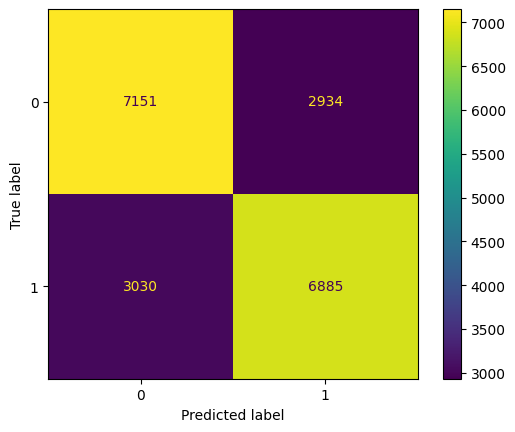



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     10085
           1       0.70      0.69      0.70      9915

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



=== All AUC Scores ===
[0.54710971 0.54844613 0.54706186 0.55350426 0.5399681 ]


=== Mean AUC Score ===
Mean AUC Score - RF:  0.5472180100000001


In [ ]:
rfc_wo = RandomForestClassifier()
rfc_wo.fit(X_train,y_train)
y_pred = rfc_wo.predict(X_test)
rfc_wo_cv_score = cross_val_score(rfc_wo, X, y, cv=5, scoring='roc_auc', verbose=2)

eval_result(y_test,y_pred,rfc_wo_cv_score,'RF','AUC')

### With Crowns (Player Performance Metric)

In [ ]:
X = sample_df.drop(['deck','winner'],axis=1).values
y = sample_df[['winner']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

#### Random Forest Implementation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


[CV] END .................................................... total time=  21.8s
[CV] END .................................................... total time=  23.3s
[CV] END .................................................... total time=  23.4s
[CV] END .................................................... total time=  22.3s


=== Confusion Matrix ===


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


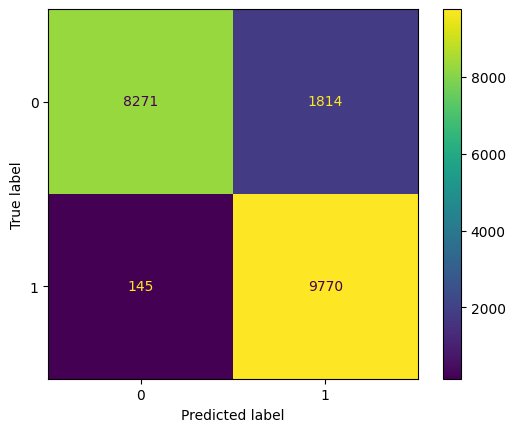



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     10085
           1       0.84      0.99      0.91      9915

    accuracy                           0.90     20000
   macro avg       0.91      0.90      0.90     20000
weighted avg       0.91      0.90      0.90     20000



=== All AUC Scores ===
[0.95099557 0.95310569 0.95384322 0.95083903 0.95388768]


=== Mean AUC Score ===
Mean AUC Score - RF:  0.95253424


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

rfc_cv_score = cross_val_score(rfc, X, y, cv=5, scoring='roc_auc', verbose=2)
eval_result(y_test,y_pred,rfc_cv_score,'RF','AUC')

#### Deep Neural Network Implementation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.1s


=== Confusion Matrix ===


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


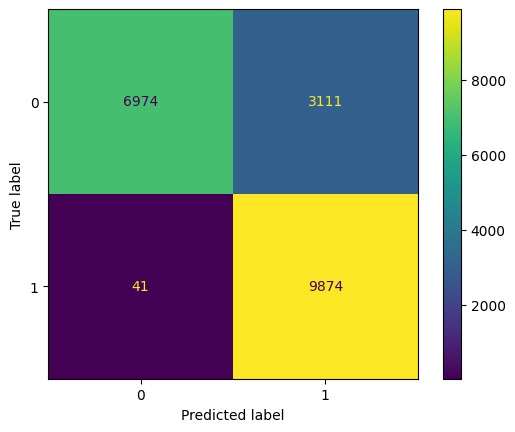



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.69      0.82     10085
           1       0.76      1.00      0.86      9915

    accuracy                           0.84     20000
   macro avg       0.88      0.84      0.84     20000
weighted avg       0.88      0.84      0.84     20000



=== All AUC Scores ===
[0.51307984 0.5119899  0.55594504 0.55576405 0.53399904]


=== Mean AUC Score ===
Mean AUC Score - Deep MLP:  0.5341555749999999


In [ ]:
mdlDnc = MLPClassifier(hidden_layer_sizes=(100,100))
mdlDnc.fit(X_train, y_train)
y_test_pred = mdlDnc.predict(X_test)

mdlDnc_cv_score = cross_val_score(mdlDnc, X, y, cv=5, scoring='roc_auc', verbose=2)
eval_result(y_test,y_test_pred,mdlDnc_cv_score,'Deep MLP','AUC')

* Without crowns, it is hard to properly predict efficacy of decks themselves
* Considering crowns is a consideration of odds; by taking into account player stats, a much clearer prediction is yielded

# Part 3: Validation
* Models above cross-validated with 5 folds
* Will also test with external validation set which was not used for training or testing

In [ ]:
val_csv = pd.read_csv('/content/drive/MyDrive/ME 379M/Hackathon 2023/Testing Only/battle_data_val.csv')
X_val = val_csv.drop(['Unnamed: 0','winner'],axis=1).values
y = val_csv[['winner']].values



=== Confusion Matrix ===


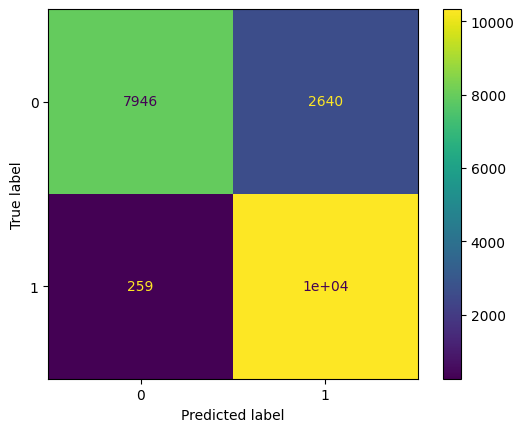



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     10586
           1       0.80      0.98      0.88     10586

    accuracy                           0.86     21172
   macro avg       0.88      0.86      0.86     21172
weighted avg       0.88      0.86      0.86     21172





In [ ]:
y_pred = rfc.predict(X_val)

print('\n')
print("=== Confusion Matrix ===")
mat = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
mat.plot()
plt.show()
print('\n')
print("=== Classification Report ===")
print(classification_report(y, y_pred))
print('\n')

## Find Prediction from Deck Input

### Input Player Parameters and Opponent Info

In [ ]:
trophy_level = int(input('Trophy Level: '))
crown_odds = float(input('Crown Odds: '))
opponent_level = float(input('Opponent Average Card Level: '))
opponent_cost = float(input('Opponent Average Elixir Level: '))

Trophy Level: 6000
Crown Odds: 1.5
Opponent Average Card Level: 12
Opponent Average Elixir Level: 3.5


### Input Deck

Test Deck: 
Hog Rider 13
Musketeer 13
Cannon 13
Fireball 13
The Log 13
Ice Spirit 13
Skeletons 13
Ice Golem 13

Opponent Deck Avg Level: 13.5
Opponent Deck Avg Cost: 3.70

In [ ]:
deck_input = []
level_input = []

for i in range(8):
    card = input('Card {}: '.format(i+1))
    while card not in troops_list:
        print('Not in list. Please reinput.\n')
        card = input('Card {}: '.format(i+1))
    level = int(input('Card Level: '))
    deck_input.append(card)
    level_input.append(level)
    print('Card added to deck successfully.\n')
    
print('-------------\nDeck: ', deck_input)
print('Levels: ', level_input)

Card 1: Hog Rider
Card Level: 13
Card added to deck successfully.

Card 2: Musketeer
Card Level: 13
Card added to deck successfully.

Card 3: Cannon
Not in list. Please reinput.

Card 3: 13
Not in list. Please reinput.

Card 3: Cannons
Not in list. Please reinput.

Card 3: Barbarians
Card Level: 13
Card added to deck successfully.

Card 4: Fireball
Not in list. Please reinput.

Card 4: Fireballs
Not in list. Please reinput.

Card 4: Ice Spirit
Card Level: 13
Card added to deck successfully.

Card 5: Skeletons
Card Level: 13
Card added to deck successfully.

Card 6: Ice Golem
Card Level: 13
Card added to deck successfully.

Card 7: Archers
Card Level: 13
Card added to deck successfully.

Card 8: Goblin Gang
Card Level: 13
Card added to deck successfully.

-------------
Deck:  ['Hog Rider', 'Musketeer', 'Barbarians', 'Ice Spirit', 'Skeletons', 'Ice Golem', 'Archers', 'Goblin Gang']
Levels:  [13, 13, 13, 13, 13, 13, 13, 13]


### Convert Data and Run

In [ ]:
avg_cost = float(input('Average Cost of Deck: '))

Average Cost of Deck: 3.5


In [ ]:
avg_level = sum(level_input)/8

input_df = pd.DataFrame.from_dict({
    'startingTrophies2': trophy_level,
    'avg_deck_level': (avg_level+opponent_level)/2,
    'avg_elixir_cost': (avg_cost+opponent_cost)/2,
    'deck': [deck_input],
    'crowns': crown_odds,
    'avg_cards_level': avg_level,
    'avg_cost': 0
})

for spec in stats_df.drop(['type', 'category', 'cost'], axis=1).columns[1:]:
    input_df[spec] = input_df['deck'].apply(lambda x: sum(stats_df.loc[stats_df['name'].isin(x), spec]))

troops_list = stats_df['name'].loc[stats_df['type']=='Troop'].to_list() 
input_df['Troop_num'] = input_df['deck'].apply(lambda x: how_many_A_in_B(x,troops_list))
for card_type in list(card_stats_df['category'].unique()):
    input_df[card_type] = input_df['deck'].apply(lambda x: how_many_A_in_B(x,list(card_stats_df['name'].loc[card_stats_df['category']==card_type])))

all_names = cards_df.index
all_names = [i for i in all_names if i is not None]
name_df = pd.DataFrame(columns=all_names)
name_df = pd.DataFrame(input_df['deck'].apply(lambda x: [1 if name in x else 0 for name in all_names]).tolist(), columns=all_names, index=input_df.index).astype(int)

input_df = input_df.join(name_df)
input_df.drop('deck',axis=1,inplace=True)

result = 'Winner' if rfc.predict(input_df.values)[0] == 1 else 'Loser'
print(result)

Winner
